# Imports

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
# might have to pip install -q transformers
from transformers import pipeline
import random
import re

# Import Data

In [4]:
data = pd.read_csv('Recipe Reviews and User Feedback Dataset.csv')
data.head()

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


# General Data Summary

In [5]:
total_thumbs = data.groupby('recipe_code').agg({'thumbs_up': 'sum', 'thumbs_down': 'sum', 'recipe_code': 'count'})
total_thumbs.columns = ['total_thumbs_up', 'total_thumbs_down', 'count']

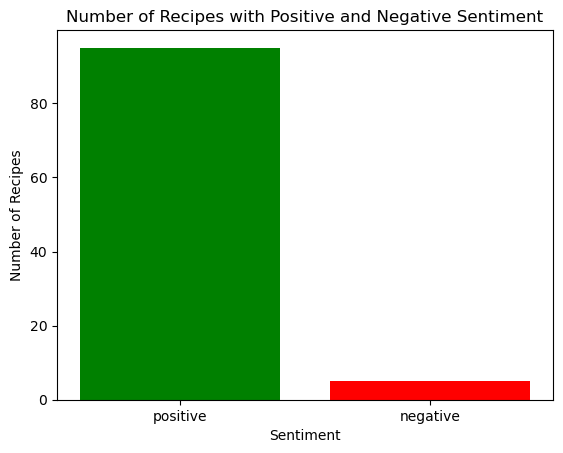

In [6]:
total_thumbs['sentiment'] = 'positive'
total_thumbs.loc[total_thumbs['total_thumbs_up'] < total_thumbs['total_thumbs_down'], 'sentiment'] = 'negative'

# Count the number of recipes with positive and negative sentiment
sentiment_counts = total_thumbs['sentiment'].value_counts()

# Plotting
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Recipes')
plt.title('Number of Recipes with Positive and Negative Sentiment')
plt.show()


# Sentiment Analysis of Reviews

In [7]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [8]:
x = sentiment_pipeline(data['text'][0])

In [9]:
x

[{'label': 'POSITIVE', 'score': 0.9997697472572327}]

In [10]:
x[0]['score']

0.9997697472572327

## Broaden this
Do reviews with more positive scores recieve more thumbs up? Same with vice versa

In [70]:
sentiment_df = data
sentiment_df["sentiment_score"] = None

In [71]:
def remove_html_entity(input_string):
    input_string = str(input_string)
    result_string = input_string.replace("&#39;", "")
    result_string = result_string.replace("<h1>", "")
    result_string = result_string.replace("</h1>", "")
    result_string = result_string.replace("<span>", "")
    result_string = result_string.replace("</span>", "")
    result_string = result_string.replace("<li>", "")
    result_string = result_string.replace("</li>", "")
    result_string = result_string.replace("<i>", "")
    result_string = result_string.replace("</i>", "")
    result_string = result_string.replace("<h2>", "")
    result_string = result_string.replace("</h2>", "")
    result_string = result_string.replace("<ul>", "")
    result_string = result_string.replace("</ul>", "")
    result_string = result_string.replace("<b>", "")
    result_string = result_string.replace("</b>", "")
    result_string = result_string.replace("\xa0", "")
    

    return result_string

In [72]:
# Change the object to a list
texts = []
for t in range(len(sentiment_df['text'])):
    text = sentiment_df['text'][t]
    text = remove_html_entity(text)
    if str(text) != "nan":
        texts.append(text)
        if len(text) > 2000:
            text_1 = text[0:1500]
            text_2 = text[1500:]
            sentiment_1 = sentiment_pipeline(text_1)[0]['score']
            sentiment_2 = sentiment_pipeline(text_2)[0]['score']
            sentiment_df["sentiment_score"][t] = (sentiment_1  + sentiment_2)/2
        else:
            sentiment_df["sentiment_score"][t] = sentiment_pipeline(text)[0]['score']
    else:
        sentiment_df["sentiment_score"][t] = 0

/var/folders/pz/lc5f5cgd1m5_ghmjddlz8r600000gn/T/ipykernel_96296/2769961053.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["sentiment_score"][t] = sentiment_pipeline(text)[0]['score']
/var/folders/pz/lc5f5cgd1m5_ghmjddlz8r600000gn/T/ipykernel_96296/2769961053.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["sentiment_score"][t] = 0
/var/folders/pz/lc5f5cgd1m5_ghmjddlz8r600000gn/T/ipykernel_96296/2769961053.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [73]:
sentiment_df.to_csv('sentiment_df.csv', index=False)

# Question 2
How do the reviews change overtime if at all? 
- Use timestamps to make “timeline” of review sentiments overtime
- Use the running average of the ratings to look for deviations from average. 

## Step 1: One recipie
Get all review for one recipie and track sentiments & thumbs up over time

In [23]:
random_idx = random.randint(1, len(data))
recipie_code = data['recipe_code'][random_idx]

In [24]:
recipie_reviews = data[data['recipe_code'] == recipie_code]
# sort by time
recipie_reviews = recipie_reviews.sort_values(by='created_at')

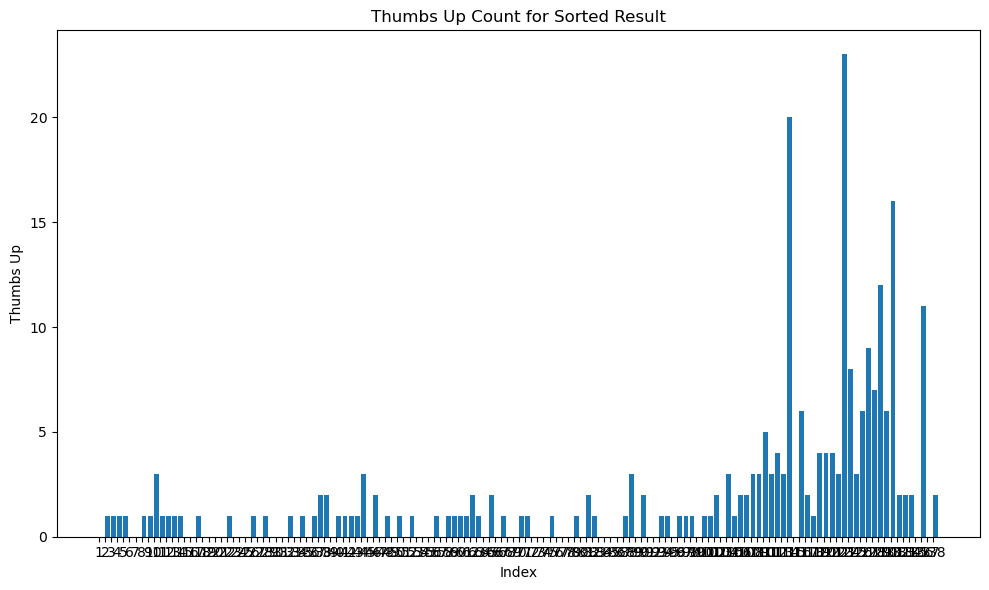

In [28]:
# Plotting the bar plot
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.bar(range(len(recipie_reviews)), recipie_reviews['thumbs_up'], align='edge')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Thumbs Up')
plt.title('Thumbs Up Count for Sorted Result')
plt.xticks(range(len(recipie_reviews)), range(1, len(recipie_reviews) + 1))

# Show plot
plt.tight_layout()
plt.show()

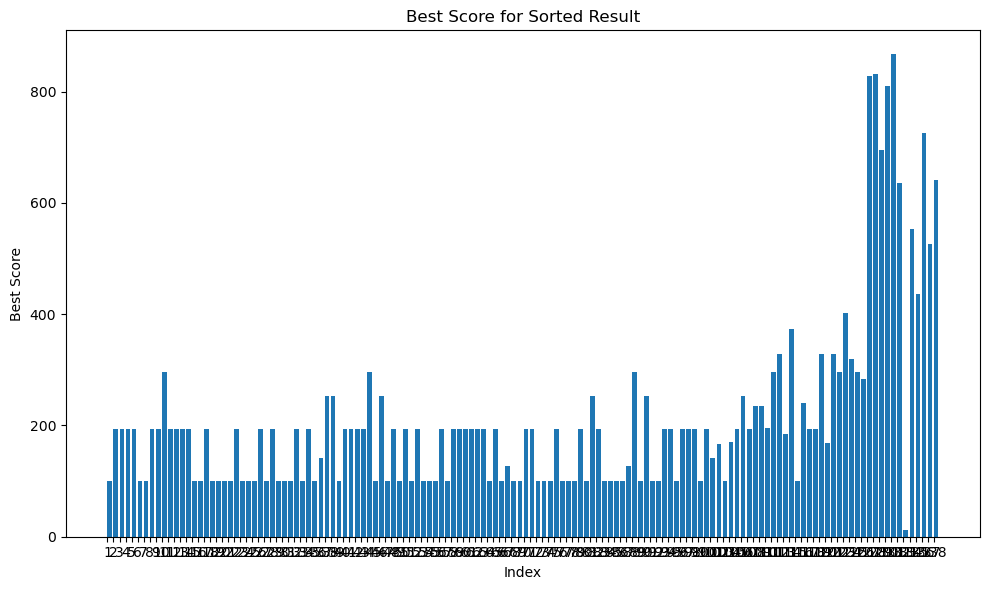

In [29]:
# Plotting the bar plot
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.bar(range(len(recipie_reviews)), recipie_reviews['best_score'], align='edge')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Best Score')
plt.title('Best Score for Sorted Result')
plt.xticks(range(len(recipie_reviews)), range(1, len(recipie_reviews) + 1))

# Show plot
plt.tight_layout()
plt.show()

### Sentiment

In [83]:
random_idx = random.randint(1, len(sentiment_df))
recipie_code = sentiment_df['recipe_code'][random_idx]
recipie_reviews = sentiment_df[sentiment_df['recipe_code'] == recipie_code]
recipie_reviews = recipie_reviews.sort_values(by='created_at')

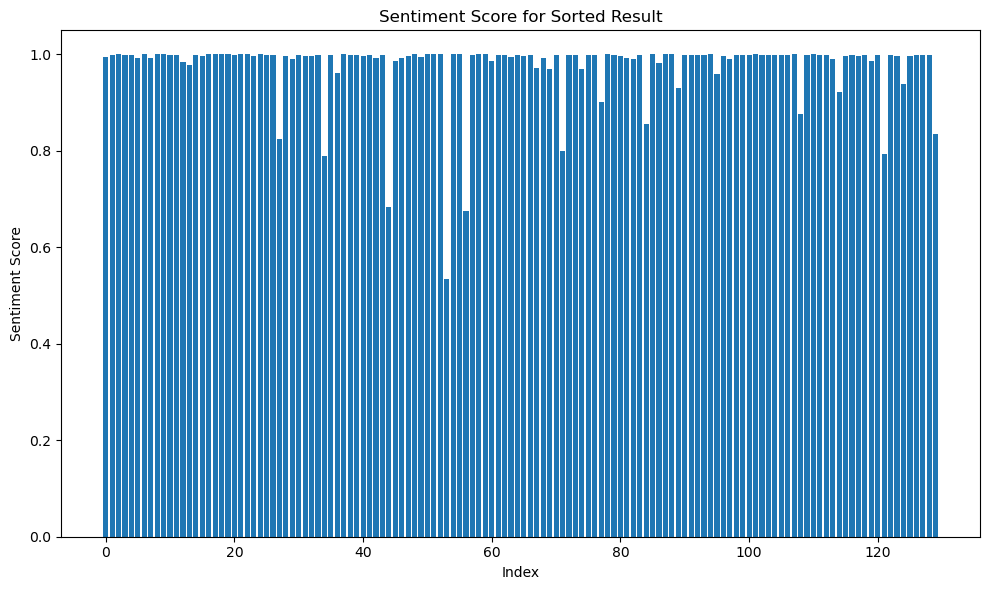

In [85]:
# Plotting the bar plot
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.bar(range(len(recipie_reviews)), recipie_reviews['sentiment_score'])

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for Sorted Result')
#plt.xticks(range(len(recipie_reviews)), range(1, len(recipie_reviews) + 1))

# Show plot
plt.tight_layout()
plt.show()

looks like sentiments DO NOT change overtime but "best score" does! There are definitley some deviations though which is pretty interesting!

# Length of Review vs Sentiment